In [199]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from scipy import stats
from pandas.core import datetools
%matplotlib inline

In [147]:
month = {'JAN': 1, 'FEB':2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12}

In [148]:
DJIA_company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ]

In [149]:
new_company_list = ['ASGN',
 'AVA',
 'B',
 'BCPC',
 'CACI',
 'CBU',
 'CHE',
 'COLB',
 'FCFS',
 'FFIN',
 'FIVE',
 'GBCI',
 'GDOT',
 'HAE',
 'HI',
 'IART',
 'JBT',
 'KFY',
 'KS',
 'NEOG',
 'NSP',
 'PDCE',
 'PSB',
 'QLYS',
 'SIGI',
 'SKYW',
 'STMP',
 'TREX',
 'VAC',
 'WWE']

In [150]:
# Import high frequency data
def import_data(path, company_list):
    path = path               #r'D:\data_raw' # Please put all .csv documents into one folder
    company_list = company_list# Input company name as a list
    company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
    for company in company_list:
        frame = pd.DataFrame()
        list_ = []
        allFiles = glob.glob(path + '/' +company +'_' + '*.csv')
        allFiles.reverse()
        #print (allFiles)
        for file_ in allFiles:
            df = pd.read_csv(file_, index_col=None, header=0, usecols=[0,1], skiprows=[1,])
            list_.append(df)
        frame = pd.concat(list_)
        company_data[company] = frame
        company_data[company].index = pd.RangeIndex(len(company_data[company].index))
    return company_data

In [151]:
new_company_data = import_data(r'./New_Data', new_company_list)

In [152]:
def print_shape(dict_df, company_list):
    for com in company_list:
        print (com, dict_df[com].shape)

In [153]:
print_shape(new_company_data, new_company_list)

ASGN (97217, 2)
AVA (97975, 2)
B (95697, 2)
BCPC (82979, 2)
CACI (91975, 2)
CBU (91644, 2)
CHE (85200, 2)
COLB (94750, 2)
FCFS (92945, 2)
FFIN (89271, 2)
FIVE (98667, 2)
GBCI (97197, 2)
GDOT (97619, 2)
HAE (96836, 2)
HI (94420, 2)
IART (93950, 2)
JBT (88779, 2)
KFY (97263, 2)
KS (98597, 2)
NEOG (86160, 2)
NSP (88395, 2)
PDCE (98858, 2)
PSB (79732, 2)
QLYS (93020, 2)
SIGI (90061, 2)
SKYW (97536, 2)
STMP (92793, 2)
TREX (95969, 2)
VAC (94561, 2)
WWE (96903, 2)


In [156]:
def get_feature(company_data, company_list, quantile = False):
    high_mom_daily_data = {}
    list_big_data = []
    for com in company_list:
        list_temp = []
        date_idx = []
        high_mom_daily_data[com] = pd.DataFrame(columns = [com+'_RDVar', com+'_RDSkew', com+'_RDKurt'])
        date_idx_s = np.array(company_data[com].loc[pd.isnull(company_data[com].Close), ].index)
        date_idx_e = np.append(date_idx_s[1:], company_data[com].shape[0])
        #date_idx_e = date_idx_s[1:]
        for i, j in zip(date_idx_s, date_idx_e):
            date = company_data[com]['Time Interval'][i][:9]
            d = date[:2]
            m = str(month[date[2:5]])
            y = date[5:]
            date_idx.append(d+'/'+m+'/'+y)
            log_r = np.log(company_data[com].Close[i+1: j]).diff().dropna()
            RDVar = np.sum(np.square(log_r))
            if quantile: # quantile based measure of kurtosis and skewness
                RDSkew = (np.percentile(log_r, 75) + np.percentile(log_r, 25) - 2*np.percentile(log_r, 50))/ \
                                    (np.percentile(log_r, 75) - np.percentile(log_r, 50))
                RDKurt = ((np.percentile(log_r, 87.5)-np.percentile(log_r, 62.5)) + \
                                  (np.percentile(log_r, 37.5)-np.percentile(log_r, 12.5))) \
                                    /(np.percentile(log_r, 75) - np.percentile(log_r, 25)) - 1.23
            else:
                RDSkew = np.sqrt(len(log_r)) * np.sum(log_r**3) / RDVar**1.5
                RDKurt = len(log_r) * np.sum(log_r**4) / RDVar**2
            list_temp.append({com+'_RDVar': RDVar, com+'_RDSkew': RDSkew, com+'_RDKurt': RDKurt})
        high_mom_daily_data[com] = high_mom_daily_data[com].append(list_temp)
        high_mom_daily_data[com].index = pd.to_datetime(date_idx, dayfirst=True)
        list_big_data.append(high_mom_daily_data[com])
    return list_big_data, high_mom_daily_data

In [157]:
new_list_big_data, new_high_mom_daily_data = get_feature(new_company_data, new_company_list)

In [158]:
len(new_high_mom_daily_data.keys())

30

In [159]:
for com in new_company_list[:7]+new_company_list[8:]:
    print(com, new_high_mom_daily_data[com].shape)

ASGN (1257, 3)
AVA (1257, 3)
B (1257, 3)
BCPC (1257, 3)
CACI (1257, 3)
CBU (1257, 3)
CHE (1257, 3)
FCFS (1257, 3)
FFIN (1257, 3)
FIVE (1257, 3)
GBCI (1257, 3)
GDOT (1257, 3)
HAE (1257, 3)
HI (1257, 3)
IART (1257, 3)
JBT (1257, 3)
KFY (1257, 3)
KS (1257, 3)
NEOG (1257, 3)
NSP (1257, 3)
PDCE (1257, 3)
PSB (1257, 3)
QLYS (1257, 3)
SIGI (1257, 3)
SKYW (1257, 3)
STMP (1257, 3)
TREX (1257, 3)
VAC (1257, 3)
WWE (1257, 3)


In [160]:
def concat_big_data(list_big_data):
    big_data = pd.concat(list_big_data, axis = 1)
    # drop na rows
    big_data.dropna(axis = 0, how = 'any', inplace = True)
    return big_data

In [161]:
new_big_data = concat_big_data(new_list_big_data)

In [162]:
new_big_data.head()

,ASGN_RDVar,ASGN_RDSkew,ASGN_RDKurt,AVA_RDVar,AVA_RDSkew,AVA_RDKurt,B_RDVar,B_RDSkew,B_RDKurt,BCPC_RDVar,...,STMP_RDKurt,TREX_RDVar,TREX_RDSkew,TREX_RDKurt,VAC_RDVar,VAC_RDSkew,VAC_RDKurt,WWE_RDVar,WWE_RDSkew,WWE_RDKurt
2013-03-05,0.000507,0.846212,3.944336,0.000096,0.839482,5.131294,0.000229,0.968037,7.062124,0.000377,...,2.596510,0.000211,0.242298,3.628397,0.000417,-1.579410,6.274042,0.000366,0.278593,5.771441
2013-03-06,0.000529,0.715261,4.820534,0.000083,0.287160,5.034838,0.000086,1.359039,5.093999,0.000284,...,3.656195,0.000292,-0.922603,3.565105,0.000358,0.167530,12.924301,0.000246,0.303202,3.003903
2013-03-07,0.000190,0.080078,3.523982,0.000096,0.861816,10.480583,0.000146,0.478001,3.819178,0.000490,...,7.755738,0.000243,-0.568247,4.222335,0.000100,-0.997731,6.148391,0.000779,0.176593,3.685906
2013-03-08,0.000150,0.937073,3.838314,0.000089,1.352039,8.870945,0.000088,-1.080502,5.137641,0.000306,...,4.974880,0.000088,-0.436238,6.140698,0.000226,-0.541602,4.696688,0.000130,0.212896,3.498331
2013-03-11,0.000222,0.438405,4.340725,0.000041,0.216835,4.410654,0.000127,1.945446,9.710063,0.000226,...,2.938193,0.000176,-0.357658,4.730107,0.000092,-0.144496,3.346344,0.000319,-0.500065,9.040559


In [163]:
new_big_data.shape

(1257, 90)

In [164]:
import pickle
with open('preprocessed_data', 'wb') as f:
    pickle.dump((new_big_data, new_high_mom_daily_data), f)

In [ ]:
############################## Ignore above, just load the pickle file ####################################

In [171]:
# Import daily data

def daily_data_import_and_data_processing(path, company_list, big_data, high_mom_daily_data): # path = 'D:\\daily_data_xls\\'
    company_daily = {}
    list_daily = []
    for com in company_list:
        company_daily[com] = pd.read_excel(path+com+'_daily.xlsx', index_col = 0, header = 0)
        list_drop = list(company_daily[com].columns.values[:-1])
        company_daily[com].drop(list_drop, axis = 1, inplace = True)
        list_daily.append(company_daily[com])

    big_data_daily = pd.concat(list_daily, axis = 1)
    big_data_daily.dropna(axis = 0, how = 'any', inplace = True)
    super_big_data = pd.concat([big_data, big_data_daily], axis = 1)
    super_big_data.dropna(axis = 0, how = 'any', inplace = True)
    print (super_big_data.shape)
    
    company_daily = {}
    high_mom_daily_data = {}
    price_com_mat = pd.DataFrame(columns = company_list)
    for com in company_list:
        index = company_list.index(com)
        high_mom_daily_data[com] = super_big_data.loc[:, [com+'_RDVar', com+'_RDSkew', com+'_RDKurt']]
        company_daily[com] = pd.DataFrame(super_big_data.loc[:, [com+'.Adjusted']])
        company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
        company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()
        
        super_big_data[com+'_logr'] = company_daily[com].Daily_logr
        high_mom_daily_data[com][com+'_DR'] = company_daily[com].Daily_logr
        price_com_mat[com] = company_daily[com].iloc[:,0]
        print (company_daily[com].shape)
    return super_big_data, high_mom_daily_data, price_com_mat

In [172]:
s_b_d, h_m_d_d, p_c_m = \
        daily_data_import_and_data_processing('./New_Daily_Data/', new_company_list, new_big_data, new_high_mom_daily_data)

(1257, 120)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)
(1257, 3)


In [173]:
s_b_d.to_csv('./new_super_big_data.csv')

In [174]:
for com in new_company_list:
    h_m_d_d[com].to_csv('./new_output_data/'+com+'.csv')

In [175]:
p_c_m.to_csv('./new_price_com_mat.csv')

In [ ]:
################################ Data saved to csv file #############################################

In [217]:
# Construct weekly data (5 trading days a week)
def compute_data(frequency, high_mom_daily_data, company_list):
    if frequency == 'weekly':
        weekly_data = {}
        for com in company_list:
            weekly_data[com] = pd.DataFrame()
            weekly_data[com]['R'] = high_mom_daily_data[com][com+'_DR'].rolling(5).sum()[4::5]
            weekly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com][com+'_RDVar'].rolling(5).mean()[4::5])
            weekly_data[com]['RSkew'] = high_mom_daily_data[com][com+'_RDSkew'].rolling(5).mean()[4::5]
            weekly_data[com]['RKurt'] = high_mom_daily_data[com][com+'_RDKurt'].rolling(5).mean()[4::5]
        return weekly_data
    if frequency == 'monthly':
        # Construct monthly data (20 trading days a month)
        monthly_data = {}
        for com in company_list:
            monthly_data[com] = pd.DataFrame()
            monthly_data[com]['R'] = high_mom_daily_data[com][com+'_DR'].rolling(20).sum()[19::20]
            monthly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com][com+'_RDVar'].rolling(20).mean()[19::20])
            monthly_data[com]['RSkew'] = high_mom_daily_data[com][com+'_RDSkew'].rolling(20).mean()[19::20]
            monthly_data[com]['RKurt'] = high_mom_daily_data[com][com+'_RDKurt'].rolling(20).mean()[19::20]
        return monthly_data

In [218]:
new_monthly_data = compute_data('monthly', h_m_d_d, new_company_list)

In [219]:
new_monthly_data['AVA'].head()

,R,RVol,RSkew,RKurt
2013-04-02,NaN,0.134018,0.403693,5.258859
2013-04-30,0.015449,0.141167,0.075556,6.018293
2013-05-29,-0.046696,0.153422,-0.057751,5.241440
2013-06-26,0.007522,0.200207,0.269754,5.138047
2013-07-25,0.075392,0.173009,0.162283,5.162656


In [220]:
new_monthly_data['AVA'].shape

(62, 4)

In [221]:
# Split data into train and test data
def split_data(data, last, company_list):
    test_data = {}
    for com in company_list:
        test_data[com] = data[com][-last: ]
        data[com] = data[com][:-last]
    return data, test_data

In [222]:
new_monthly_data, new_monthly_test_data = split_data(new_monthly_data, 12, new_company_list)

In [223]:
total_month = new_monthly_data['AVA'].shape[0]
total_month

50

In [226]:
# Cross sectional regression on data
def cross_sectional_regression(data, data_length, company_list):
    from statsmodels.tools.tools import add_constant
    beta_pval = pd.DataFrame(columns = ['intercept', 'b_vol', 'b_skew','b_kurt', \
                                                                    'vol_p_val', 'skew_p_val','kurt_p_val'])
    list_cbp = []
    for i in range(data_length-1):
        next_return =[]
        cur_vol = []
        cur_skew = []
        cur_kurt = []
        for com in company_list:
            date_index = data[com].index
            next_return.append(data[com].R[date_index[i+1]])
            cur_vol.append(data[com].RVol[date_index[i]])
            cur_skew.append(data[com].RSkew[date_index[i]])
            cur_kurt.append(data[com].RKurt[date_index[i]])
        X = np.column_stack((cur_vol, cur_skew, cur_kurt))
        X = add_constant(X)
        lm = sm.OLS(next_return, X).fit()
        #print(lm.params)
        #print(lm.pvalues)
        list_cbp.append({'intercept': lm.params[0], 'b_vol': lm.params[1], 'b_skew': lm.params[2], 'b_kurt': lm.params[3], \
                         'vol_p_val': lm.pvalues[1], 'skew_p_val': lm.pvalues[2], 'kurt_p_val': lm.pvalues[3]})
    beta_pval = beta_pval.append(list_cbp)
    return beta_pval

In [227]:
new_monthly_beta_pval = cross_sectional_regression(new_monthly_data, total_month, new_company_list)

In [228]:
new_monthly_beta_pval.head()

,intercept,b_vol,b_skew,b_kurt,vol_p_val,skew_p_val,kurt_p_val
0,0.046368,-0.135643,-0.008342,-0.002334,0.369860,0.900283,0.892524
1,-0.063404,0.378748,-0.041272,0.001038,0.007175,0.404685,0.932103
2,-0.007037,0.221709,-0.062795,-0.007055,0.260791,0.430594,0.652285
3,0.209323,0.022262,-0.055478,-0.024143,0.810064,0.064342,0.001955
4,-0.174289,0.291037,-0.014686,0.016863,0.155226,0.814641,0.435519


In [229]:
# IC time series of vol, skew and kurt
def information_coefficient(data, data_length, company_list):
    IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
    list_dict = []
    for i in range(data_length - 1):
        next_return =[]
        cur_vol = []
        cur_skew = []
        cur_kurt = []
        for com in company_list:
            date_index = data[com].index
            next_return.append(data[com].R[date_index[i+1]])
            cur_vol.append(data[com].RVol[date_index[i]])
            cur_skew.append(data[com].RSkew[date_index[i]])
            cur_kurt.append(data[com].RKurt[date_index[i]])

        vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
        skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
        kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)

        list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                                  'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
    IC = IC.append(list_dict)
    IC.index = data[company_list[0]].index[1:]
    return IC

In [230]:
new_monthly_IC = information_coefficient(new_monthly_data, total_month, new_company_list)

In [232]:
new_monthly_IC.head()

,vol_Rank_IC,vol_pvalue,skew_Rank_IC,skew_pvalue,kurt_Rank_IC,kurt_pvalue
2013-04-30,-0.171969,0.363517,-0.036707,0.847291,0.018465,0.922848
2013-05-29,0.383315,0.036536,-0.124360,0.512625,0.229366,0.222752
2013-06-26,0.175083,0.354758,-0.054060,0.776621,-0.007786,0.967426
2013-07-25,0.018465,0.922848,-0.390434,0.032916,-0.498999,0.005000
2013-08-22,0.115907,0.541907,-0.235150,0.210981,0.085651,0.652694


In [235]:
def IC_IR(IC):
    IC_mean = IC.mean()
    std = IC.std()
    IC_IR = IC_mean / std
    print ('vol_Rank_IC: ', IC_IR[0], '\nskew_Rank_IC: ', IC_IR[2], '\nkurt_Rank_IC: ', IC_IR[4],)

In [236]:
IC_IR(new_monthly_IC)

vol_Rank_IC:  0.0574342969437 
skew_Rank_IC:  -0.283185981261 
kurt_Rank_IC:  0.0175829355283


In [239]:
# IC plot of vol on weekly data
def IC_plot(IC, feature):
    plt.figure(figsize=(20,10))
    x11 = IC[feature+'_pvalue'][(IC[feature+'_pvalue'] < 0.05) & (IC[feature+'_Rank_IC'] >= 0)].index
    y11 = IC[feature+'_Rank_IC'][x11]
    x12 = IC[feature+'_pvalue'][(IC[feature+'_pvalue'] < 0.05) & (IC[feature+'_Rank_IC'] < 0)].index
    y12 = IC[feature+'_Rank_IC'][x12]
    x2 = IC[feature+'_pvalue'][IC[feature+'_pvalue'] >= 0.05].index
    y2 = IC[feature+'_Rank_IC'][x2]
    print('Positive significant rate: ', len(x11)/IC.shape[0], 'Negative significant rate: ', len(x12)/IC.shape[0])
    plt.plot(y11, 'o', color='red')
    plt.plot(y12, 'o', color='blue')
    plt.plot(y2, 'o', alpha=0.5, label=feature+'_Rank_IC', color='grey')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

Positive significant rate:  0.04081632653061224 Negative significant rate:  0.02040816326530612


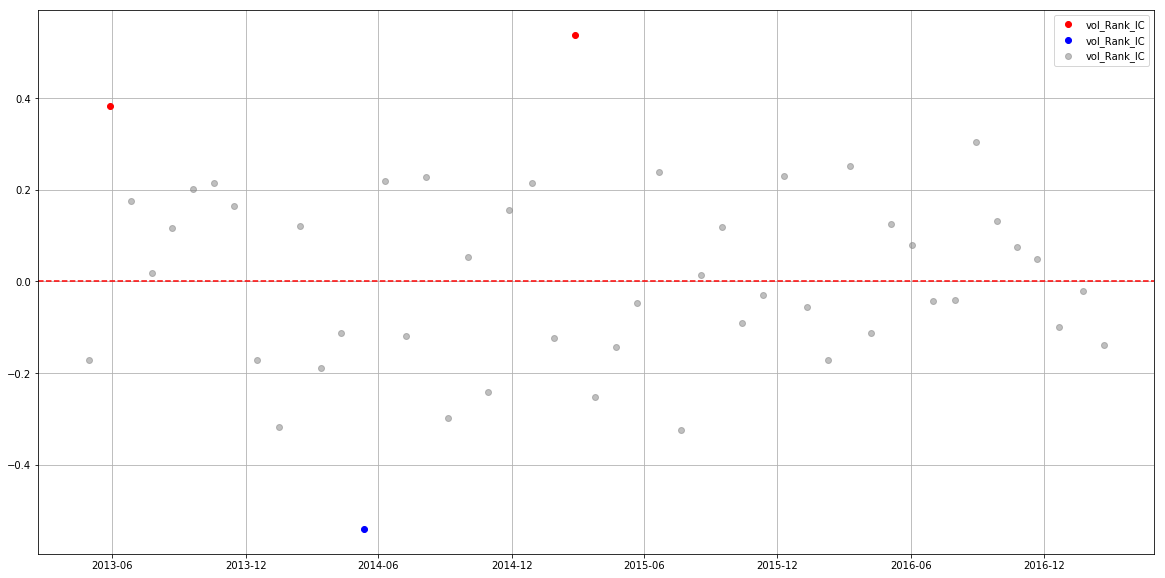

Positive significant rate:  0.04081632653061224 Negative significant rate:  0.10204081632653061


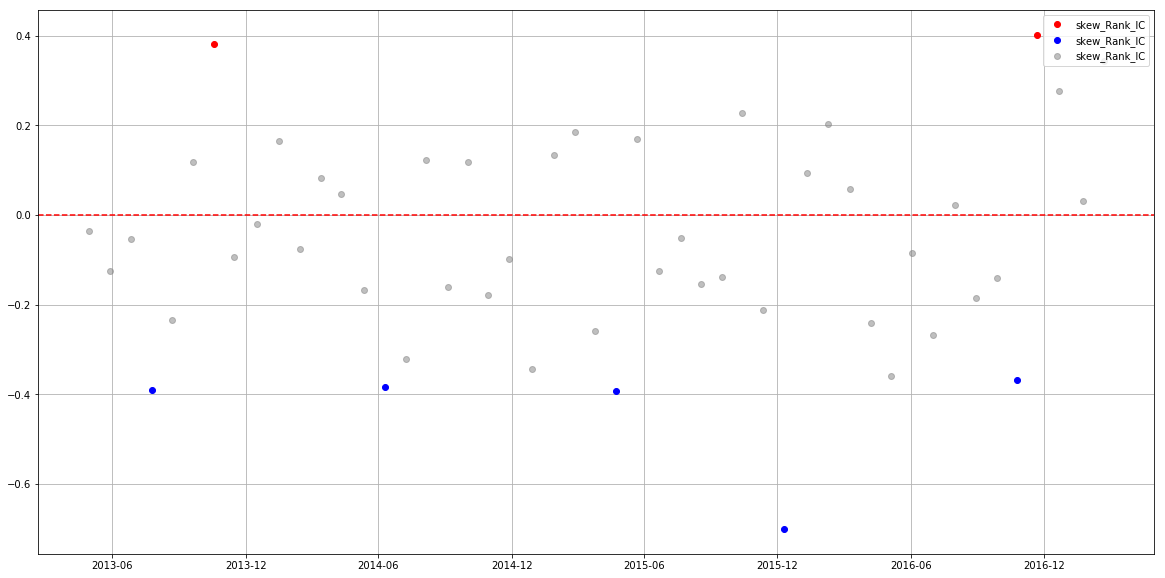

Positive significant rate:  0.0 Negative significant rate:  0.02040816326530612


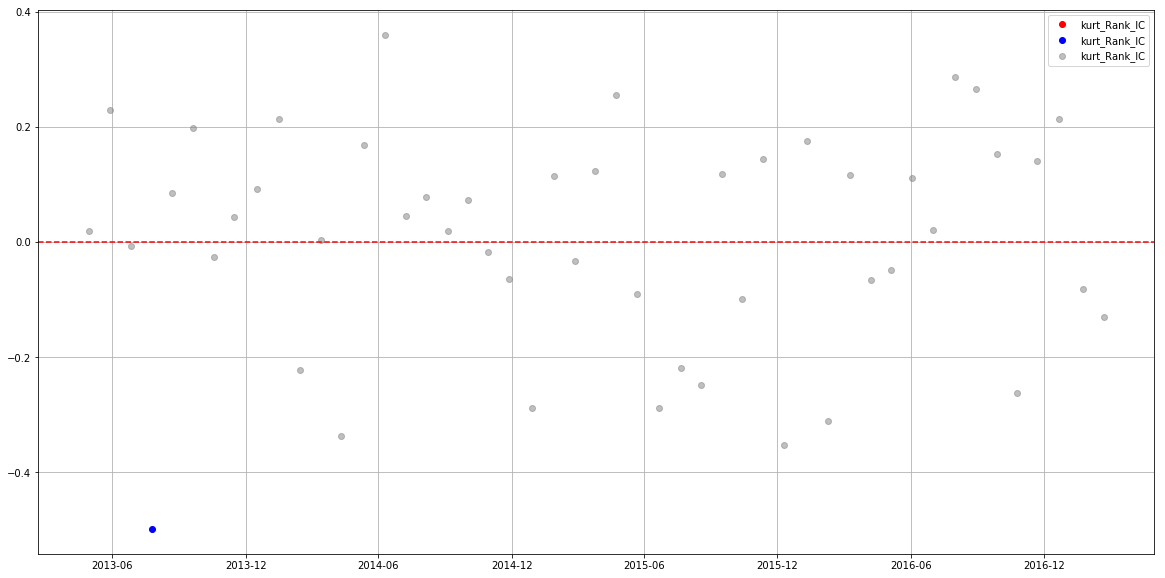

In [243]:
IC_plot(new_monthly_IC, 'vol')
IC_plot(new_monthly_IC, 'skew')
IC_plot(new_monthly_IC, 'kurt')

In [252]:
# stocks having significant beta1_vol
def significant_beta(beta_pval):
    return beta_pval[(beta_pval.vol_p_val <= 0.05) | (beta_pval.skew_p_val <= 0.05) | (beta_pval.kurt_p_val <= 0.05)]

In [253]:
significant_beta(new_monthly_beta_pval)

,intercept,b_vol,b_skew,b_kurt,vol_p_val,skew_p_val,kurt_p_val
1,-0.063404,0.378748,-0.041272,0.001038,0.007175,0.404685,0.932103
3,0.209323,0.022262,-0.055478,-0.024143,0.810064,0.064342,0.001955
6,0.021208,0.188927,0.149081,-0.003049,0.362535,0.044353,0.819230
12,0.296036,-0.511139,-0.042711,-0.031863,0.005049,0.501997,0.039017
13,0.069512,-0.273898,-0.049372,0.003340,0.005942,0.290402,0.640427
17,0.083172,-0.167891,-0.017370,-0.001100,0.044289,0.534435,0.834437
21,-0.039320,0.425868,-0.135909,-0.002881,0.003106,0.021801,0.784958
23,-0.100190,0.573245,-0.012563,-0.000290,0.005510,0.864773,0.989525
33,-0.044116,0.072717,-0.122779,0.004058,0.304917,0.000081,0.528772
44,-0.038433,0.179168,-0.136993,-0.003848,0.335893,0.018947,0.693127


In [256]:
def plot_beta(beta_pval, data_length):
    plt.plot(beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
    plt.plot(range(data_length+1), [0 for i in range(data_length+1)], 'r--')
    
    plt.plot(beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
    plt.plot(range(data_length+1), [0 for i in range(data_length+1)], 'r--')
    
    plt.plot(beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
    plt.plot(range(data_length+1), [0 for i in range(data_length+1)], 'r--')

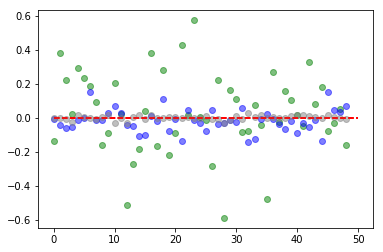

In [257]:
plot_beta(new_monthly_beta_pval, total_month)

In [265]:
# return_by_group
def group_return(data, data_length, group_name, n_stock_grp, company_list, feature):
    return_by_group = pd.DataFrame(columns = group_name)
    tmp_list = []
    for period in range(data_length-1):
        feature_this_period = sorted([(com, data[com]['R'+feature][period]) for com in company_list], key = lambda x: x[1])
        group_return_list = []
        for i in range(len(group_name)):
            cur_group, _ = zip(*feature_this_period[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
            r_ = []
            for com in cur_group:
                r_.append(data[com].R[period+1])
            group_return_list.append(np.median(r_))
        tmp_list.append(dict(zip(group_name, group_return_list)))
    return_by_group = return_by_group.append(tmp_list)
    return_by_group.index = data[company_list[0]].index[1:]
    return return_by_group

In [269]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol = group_return(new_monthly_data, total_month, group_name, n_stock_grp, new_company_list, 'Vol')
return_by_group_skew = group_return(new_monthly_data, total_month, group_name, n_stock_grp, new_company_list, 'Skew')
return_by_group_kurt = group_return(new_monthly_data, total_month, group_name, n_stock_grp, new_company_list, 'Kurt')

In [267]:
return_by_group_vol.head()

,group1,group2,group3
2013-04-30,0.003216,0.004537,-0.031218
2013-05-29,0.017588,0.059392,0.075980
2013-06-26,-0.021553,-0.010708,-0.012404
2013-07-25,0.091545,0.079869,0.088149
2013-08-22,-0.023148,-0.010869,-0.021168


In [268]:
return_by_group_vol.sum()

group1    0.632395
group2    0.673055
group3    0.951391
dtype: float64

In [271]:
return_by_group_skew.sum()

group1    0.887942
group2    0.760019
group3    0.610251
dtype: float64

In [270]:
return_by_group_kurt.sum()

group1    0.771231
group2    0.676838
group3    0.811086
dtype: float64

In [272]:
def plot_group_win(return_by_group, feature):
    feature_max = return_by_group.idxmax(axis = 1)
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.bar(return_by_group.group1.index, return_by_group.group1, label = 'group1: small'+feature, width = 5, color = 'blue')
    plt.plot(return_by_group.group1[feature_max[feature_max == 'group1'].index], 'ro')
    plt.legend(loc = 'lower left')
    plt.subplot(312)
    plt.bar(return_by_group.group2.index, return_by_group.group2, label = 'group2: mid'+feature, width = 5, color = 'orange')
    plt.plot(return_by_group.group2[feature_max[feature_max == 'group2'].index], 'ro')
    plt.legend(loc = 'lower left')
    plt.subplot(313)
    plt.bar(return_by_group.group3.index, return_by_group.group3, label = 'group3: high'+feature, width = 5, color = 'green')
    plt.plot(return_by_group.group3[feature_max[feature_max == 'group3'].index], 'ro')
    plt.legend(loc = 'lower left')
    plt.show()
    print ('group1 win rate: ', len(feature_max[feature_max == 'group1'])/float(len(feature_max)),'\n',\
           'group2 win rate: ', len(feature_max[feature_max == 'group2'])/float(len(feature_max)), '\n',\
           'group3 win rate: ', len(feature_max[feature_max == 'group3'])/float(len(feature_max)))

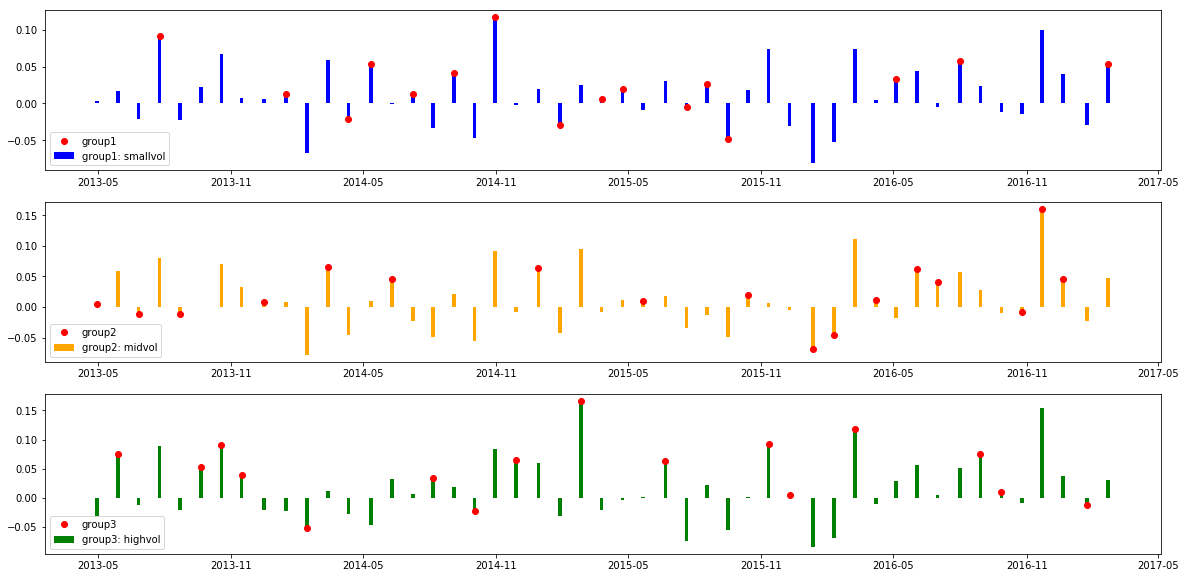

group1 win rate:  0.32653061224489793 
 group2 win rate:  0.3469387755102041 
 group3 win rate:  0.32653061224489793


In [273]:
plot_group_win(return_by_group_vol, 'vol')

In [276]:
def plot_cumsum_return(return_by_group, feature):
    plt.figure(figsize=(20,10))
    plt.plot(return_by_group.group1.index, return_by_group.group1.cumsum(), label = 'group1: low '+feature)
    plt.plot(return_by_group.group2.index, return_by_group.group2.cumsum(), label = 'group2: mid '+feature)
    plt.plot(return_by_group.group3.index, return_by_group.group3.cumsum(), label = 'group3: high '+feature)
    plt.plot(return_by_group.median(axis=1).cumsum(), label = 'group_avg', lw = 4)
    plt.legend(loc = 'upper left')

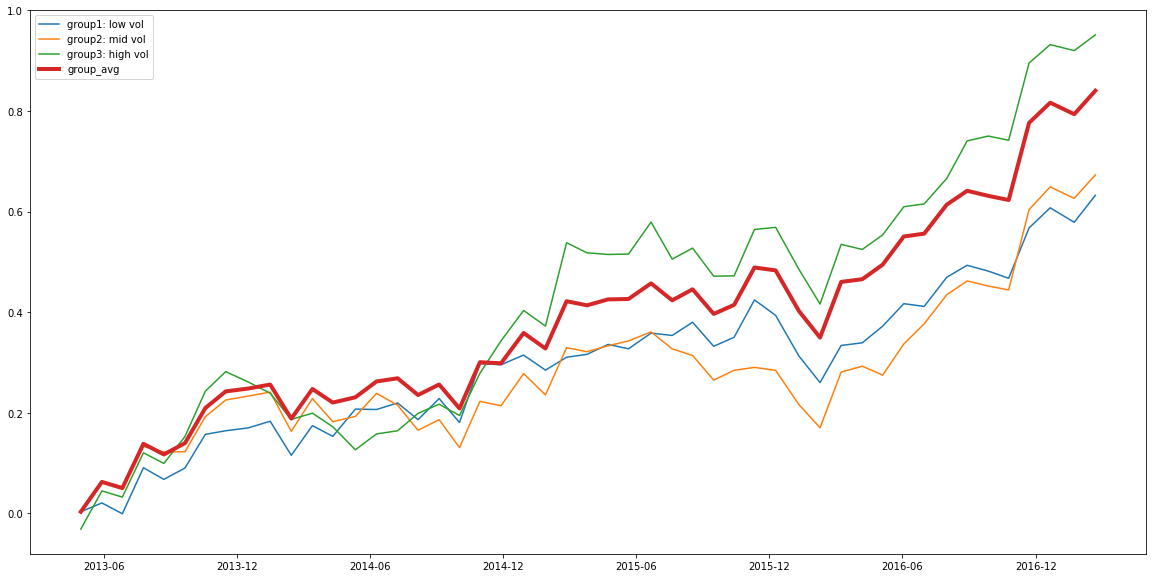

In [277]:
plot_cumsum_return(return_by_group_vol, 'vol')

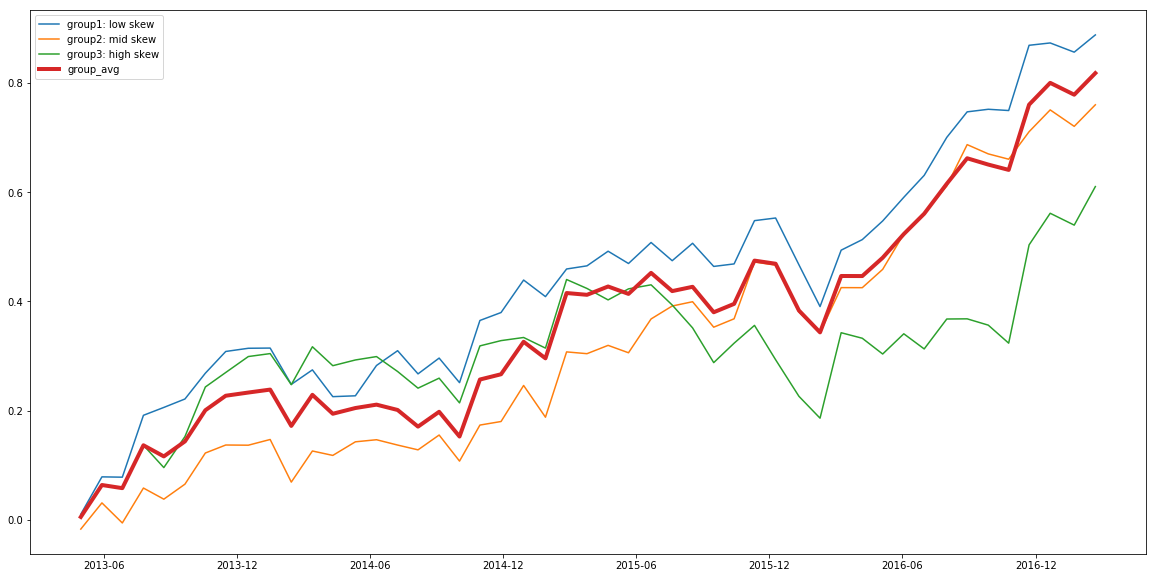

In [280]:
plot_cumsum_return(return_by_group_skew, 'skew')

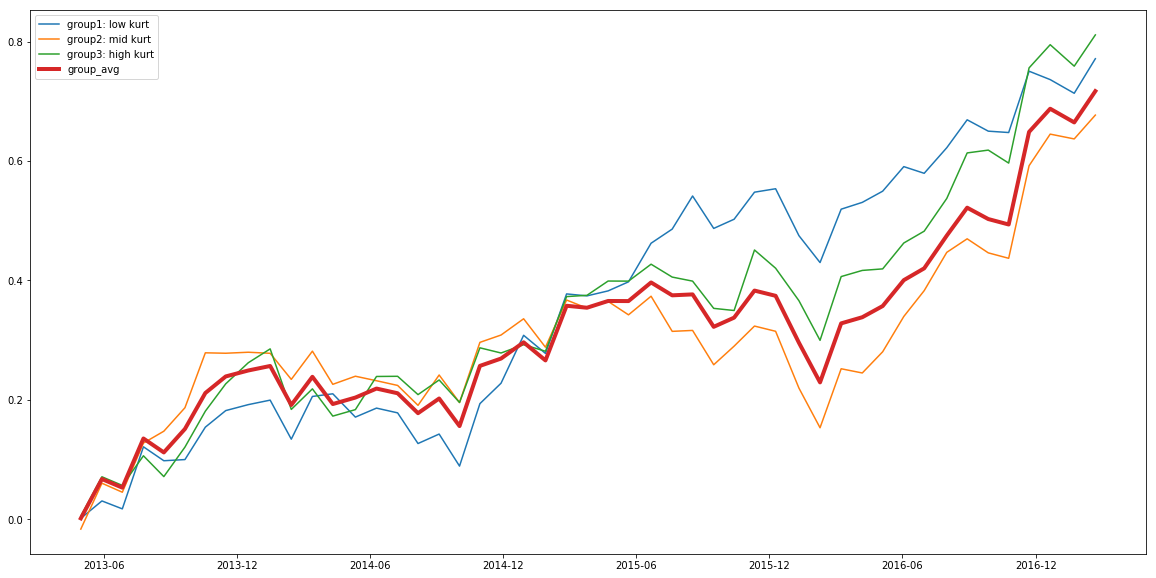

In [281]:
plot_cumsum_return(return_by_group_kurt, 'kurt')